# K-Means Clustering: What can go wrong?
In this notebook, we will take a look at few cases, where _KMC_ algorithm does not perform well or may produce unintuitive results.
In particular, we will look at the following scenarios:
1. Our guess on the number of (real) clusters is off.
2. Feature space is highly dimensional.
3. The clusters come in strange shapes.

All of these conditions can lead to problems with K-Means, so let's have a look.

In [1]:
%pylab inline
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import itertools

Populating the interactive namespace from numpy and matplotlib


## Wrong number of clusters
To make it easier, let's define a helper function `compare`, which will create and solve the clustering problem for us and then compare the results.

In [2]:
def compare(N_features, C_centers, K_clusters, dims=[0, 1], *args):
    data, targets = make_blobs(
        n_samples=n_samples if 'n_samples' in args else 400,
        n_features=N_features,
        centers=C_centers,
        cluster_std=cluster_std if 'cluster_std' in args else 0.5,
        shuffle=True,
        random_state=random_state if 'random_state' in args else 0)

    FEATS = ['x' + str(x) for x in range(N_features)]
    X = pd.DataFrame(data, columns=FEATS)
    X['cluster'] = KMeans(n_clusters=K_clusters, random_state=0).fit_predict(X)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].scatter(data[:, dims[0]], data[:, dims[1]],
        c='white', marker='o', edgecolor='black', s=20)
    axs[0].set_xlabel('x{} [a.u.]'.format(dims[0]))
    axs[0].set_ylabel('x{} [a.u.]'.format(dims[1]))
    axs[0].set_title('Original dataset')
    axs[1].set_xlabel('x{} [a.u.]'.format(dims[0]))
    axs[1].set_ylabel('x{} [a.u.]'.format(dims[1]))
    axs[1].set_title('Applying clustering')

    colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y'])
    for k in range(K_clusters):
        x = X[X['cluster'] == k][FEATS].to_numpy()
        axs[1].scatter(x[:, dims[0]], x[:, dims[1]], color=next(colors), edgecolor='k', alpha=0.5)

    plt.show()

### Too few clusters

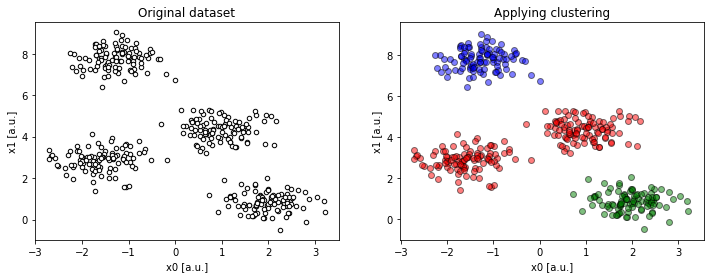

In [3]:
compare(2, 4, 3)

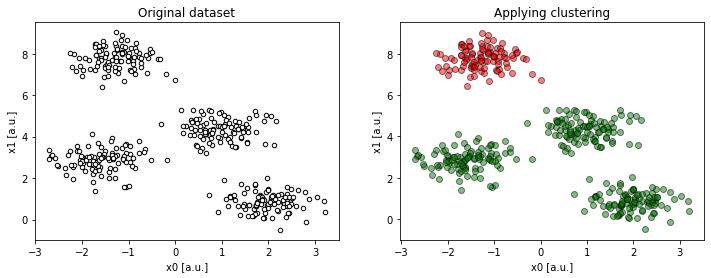

In [4]:
compare(2, 4, 2)

Despite having distinct clusters in the data, we underestimated their number. 
As a consequence, some disjoint groups of data are forced to fit into one larger cluster.
### Too many clusters

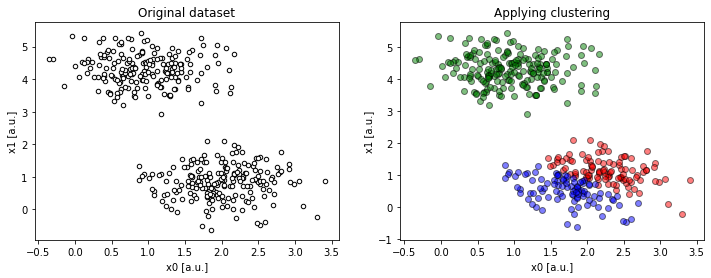

In [5]:
compare(2, 2, 3)

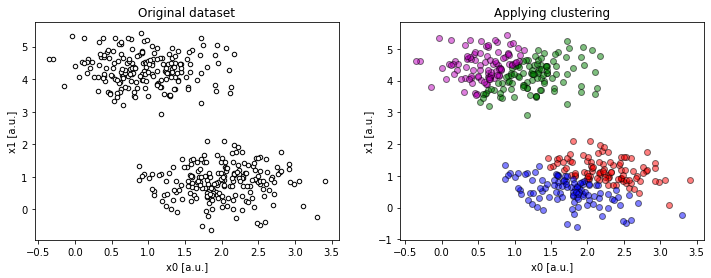

In [6]:
compare(2, 2, 4)

In contrary to the last situation, trying to wrap the data into too many clusters creates artificial boundaries within real data clusters.

## High(er) dimensional data
A dataset does not need to be that high in dimentionality before we begin to see problems.
Although visualization and thus somewhat analysis of highly dimentional data is already challenging (cursing now...), as KMC is often used to gain insight into the data, it does not help to be presented with ambiguities.

To explain the point, let's generate a three-dimensional dataset with clearly distinct clusters.

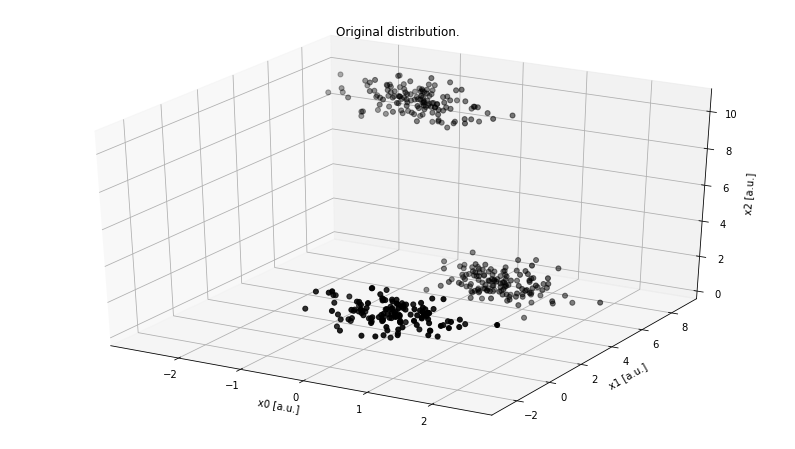

In [7]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

data, targets = make_blobs(
    n_samples=400,
    n_features=3,
    centers=3,
    cluster_std=0.5,
    shuffle=True,
    random_state=0)

ax.scatter(data[:, 0], data[:, 1], 
    zs=data[:, 2], zdir='z', s=25, c='black', depthshade=True)
ax.set_xlabel('x0 [a.u.]')
ax.set_ylabel('x1 [a.u.]')
ax.set_zlabel('x2 [a.u.]')
ax.set_title('Original distribution.')
plt.grid()
plt.show()

Although there are infinitely many ways we can project this 3D dataset onto 2D, there are three primary orthogonal sub-spaces:
* `x0 : x1`
* `x1 : x2`
* `x2 : x0`

Looking at the `x2 : x0` projection, the dataset looks like as if it only had two clusters. The lower-right "supercluster" is in fact two distinct groups and even if we guess _K_ right (`K = 3`), it looks like an apparent error, despite the clusters are very localized.

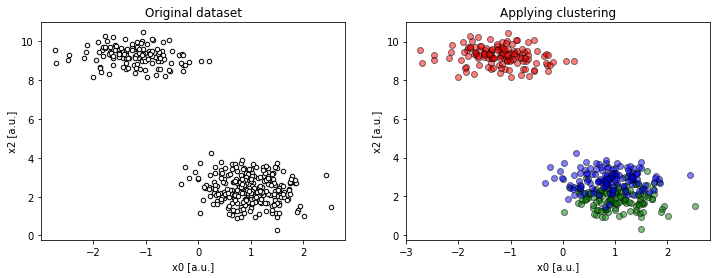

In [8]:
compare(3, 3, 3, dims=[0, 2])

To be sure, we have to look at the remaining projections to see the problem, literally, from different angles.

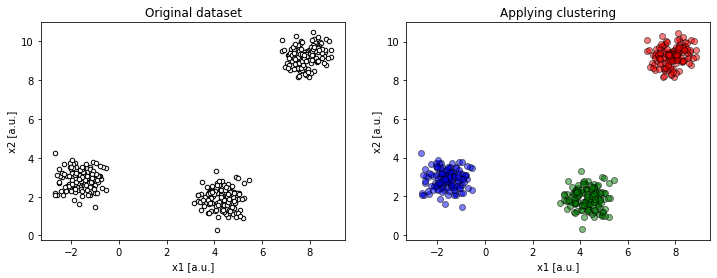

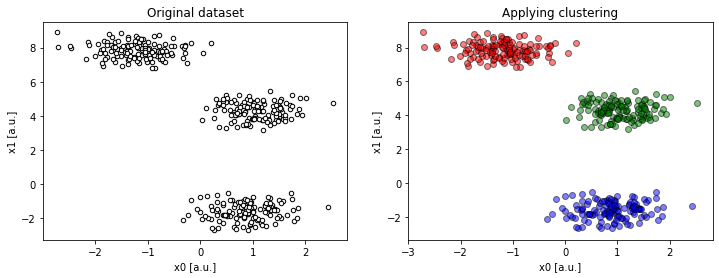

In [9]:
compare(3, 3, 3, dims=[1, 2])
compare(3, 3, 3, dims=[0, 1])

This makes more sense!

On the flip side, we had an incredible advantage.
First, with three dimensions, we were actually able to plot the entire dataset.
Secondly, the clusters that exist within the dataset were actually very distinct thus easy to spot.
Finally, the with three dimensional dataset, we were facing only three standard 2D projections.

In case of _N, N > 3_ features, we would **not be able to plot the whole dataset**, and the number of 2D projections would scale quadratically with _N_:

$$\text{number of 2D projections} = \frac{N (N - 1)}{2}$$

not to mention that the dataset may have strangely shaped or non-localized clusters, which is our next challenge.

## Irregular datasets
So far we mentioned problems that are on "our side".
We looked at a very "well-behaved" dataset and discussed issues on the analytics side.
However, what about if the dataset does not fit our solution, or, our **solution actually does not fit the problem?**
This is excatly the case, where data distribution comes in strange or irregular shapes.

Being presented with just this graph, we may be tricked into believing that there are only two clusters in the data.
However, when plotting the remaining projections, we quickly learn that this is not true.

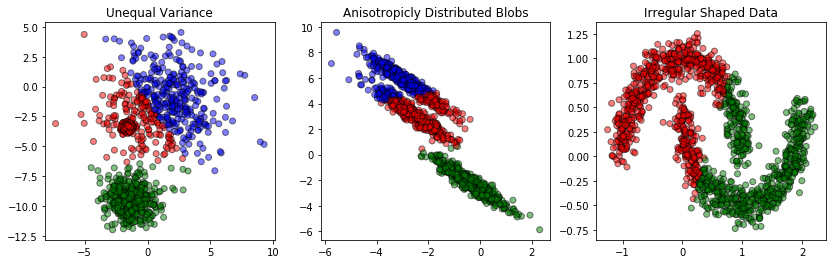

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# unequal variance
X, y = make_blobs(n_samples=1400,
    cluster_std=[1.0, 2.5, 0.2],
    random_state=2)
y_pred = KMeans(n_clusters=3, random_state=2).fit_predict(X)
colors = [['r', 'g', 'b'][c] for c in y_pred]

axs[0].scatter(X[:, 0], X[:, 1], color=colors, edgecolor='k', alpha=0.5)
axs[0].set_title("Unequal Variance")

# anisotropically distributed data
X, y = make_blobs(n_samples=1400, random_state=156)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(X)
colors = [['r', 'g', 'b'][c] for c in y_pred]

axs[1].scatter(X[:, 0], X[:, 1], color=colors, edgecolor='k', alpha=0.5)
axs[1].set_title("Anisotropicly Distributed Blobs")

# irregular shaped data
X, y = make_moons(n_samples=1400, shuffle=True, noise=0.1, random_state=120)
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X)
colors = [['r', 'g', 'b'][c] for c in y_pred]

axs[2].scatter(X[:, 0], X[:, 1], color=colors, edgecolor='k', alpha=0.5)
axs[2].set_title("Irregular Shaped Data")

plt.show()

The left graph shows data whose distribution although Gaussian, does not have equal standard deviation. 
The middle graph presents _anisotropic_ data, meaning data that is elongated along a specific axis.
Finally the right graph shows data that is completely non-Gaussian, despite organized in clear clusters.

In either case, the irregularity makes KMC algorithm underperform.
Since the algorithm treats every data point equaly and completely independently from other points, the algorithm **fails to spot any possible continuity or local variations within a cluser**.
What it does is simply taking the same metrics and applying it to every point.
As a result, the KMC algorithm may produce stange or counter-intuitive clustering within the data even if we guess _K_ correctly and the features _N_ are not that many.

If the data was not so localized around some points already and the number of features were higher, most likely out judgement would be wrong.

## Conclusions
In this notebook we have discussed three main reasons for the K-Means Clustering algorithm to give us wrong answers.

* First, as the number of clusters _K_ needs to be decided a priori, there is a high change that we will guess it wrongly.
* Secondly, clusering in higher dimensional space becomes cumbersome from the analytics point of view, in which case KMC will provide us with insights that may be misleading.
* FInally, for any inrregularly shaped data, KMC is likely to artificial clusters that do not conform to common sense.

Knowing these three fallacies, KMC is still a useful tool, especially when inspecting of the data or constructing labels.